<a href="https://colab.research.google.com/github/qcuongning/collab/blob/main/ISIC2017_efficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Với các hàm cần sử dụng backend Keras mà bị lỗi K not contribute cần đổi về keras==2.2.4


The codebase is heavily inspired by the [respotory](https://github.com/qubvel/efficientnet)



In [ ]:
%tensorflow_version

Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


In [ ]:
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,10000)

# Get Data

In [ ]:
from zipfile import ZipFile
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import os

In [ ]:
file_id = '1m0u6Ic9ZoF-FS-_HRfIHKMdxNXztWLe7'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ISIC2017')
with ZipFile('ISIC2017', 'r') as tt:
  tt.extractall("")
os.remove("ISIC2017")

In [ ]:
file_id = '1TPLVTEzAgEcFFM2KJ5ijaCzW1oY6a_wX'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('training_mask')
with ZipFile('training_mask', 'r') as tt:
  tt.extractall("")

In [ ]:
file_id = '1Z7BFrqtxm7us2a092St8VKPDOKhud8oh'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test')
with ZipFile('test', 'r') as tt:
  tt.extractall("")
os.remove("test")

In [ ]:
file_id = '1B0u9c3yeu56rtMmpGSxiY27FZ7iFRxDy'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test_mask')
with ZipFile('test_mask', 'r') as tt:
  tt.extractall("")

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import cv2

In [ ]:
file_name = 'weights_save'
if not os.path.exists(file_name):
  os.mkdir(file_name)


# Initial Data

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import tensorflow
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
import cv2, re, lmdb
import fnmatch, sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import csv
from matplotlib import pyplot as plt
seed = 1234
np.random.seed(seed)
fig=plt.figure()
FJoin = os.path.join

<Figure size 432x288 with 0 Axes>

lấy các cặp ảnh và mask

ảnh resize về 192x288

mask là binary
đầu ra imgs , masks

In [ ]:
def GetFiles(path):
    file_list, dir_list = [], []
    for dir, subdirs, files in os.walk(path):
        file_list.extend([FJoin(dir, f) for f in files])
        dir_list.extend([FJoin(dir, d) for d in subdirs])
    return file_list, dir_list

def get_mask(image_name,mask_folder):
    mask_path=os.path.join(mask_folder, image_name.replace(".jpg","_segmentation.png"))
    #print(mask_path)
    img_mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    _,img_mask = cv2.threshold(img_mask,127,255,cv2.THRESH_BINARY)
    img_mask = img_mask/255.
    return img_mask


def build_data(path,mask_folder,csv_path,img_shapes):
  w,h = img_shapes
  imgs=[]
  masks=[]
  img_name=[]
  with open(csv_path, 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        img_name.append(row[0])
  for count,file in enumerate(img_name[1:]):
        file+=".jpg"
        fullpath= os.path.join(path,file)
        msk=get_mask(file,mask_folder)
        msk=cv2.resize(msk,(w,h))
        masks.append(msk)
        image=cv2.imread(fullpath)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        #image=image/127.5-1
        image=cv2.resize(image,(w,h))
        imgs.append(image)
        if count%200 == 0:
          plt.figure(count//200)
          plt.subplot(1,2,1).imshow(image,cmap='gray')
          plt.subplot(1,2,2).imshow(msk, cmap = 'gray')
          plt.show()  
  imgs=np.asarray(imgs,dtype=np.float)
  masks=np.asarray(masks,dtype=np.float).reshape(-1,h,w,1)
  print("shape imgs: ",imgs.shape)
  print("shape masks: ",masks.shape)
  return imgs,masks

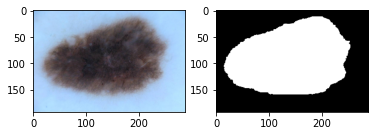

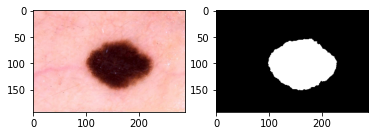

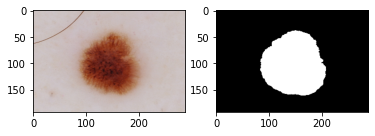

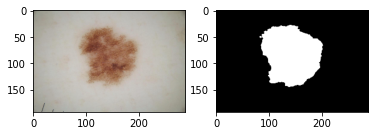

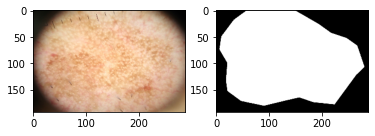

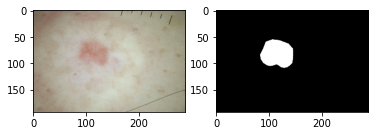

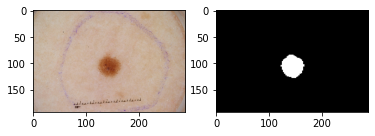

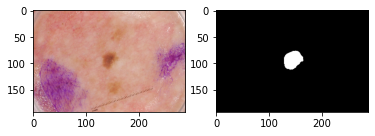

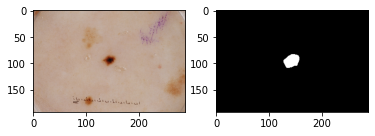

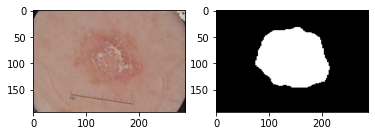

shape imgs:  (2000, 192, 288, 3)
shape masks:  (2000, 192, 288, 1)


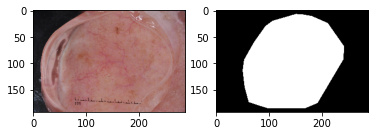

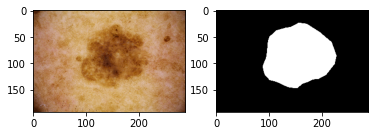

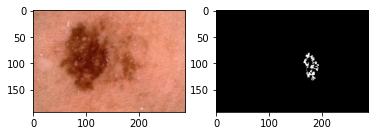

shape imgs:  (600, 192, 288, 3)
shape masks:  (600, 192, 288, 1)


In [ ]:
w = 288
h = 192
folder_train = "/content/ISIC-2017_Training_Data"
mask_train_folder = "/content/ISIC-2017_Training_Part1_GroundTruth"
csv_train = '/content/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv'

folder_test="ISIC-2017_Test_v2_Data"
mask_test_folder="ISIC-2017_Test_v2_Part1_GroundTruth"
csv_test = 'ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data_metadata.csv'



imgs,masks = build_data(folder_train,mask_train_folder, csv_train, (w,h))
imgs_test,masks_test = build_data(folder_test,mask_test_folder, csv_test, (w,h))

In [ ]:
masks=masks.reshape(masks.shape[0],masks.shape[1],masks.shape[2],1)
masks_test=masks_test.reshape(masks_test.shape[0],masks_test.shape[1],masks_test.shape[2],1)
print(imgs.shape,masks.shape,imgs_test.shape,masks_test.shape)

(2000, 192, 288, 3) (2000, 192, 288, 1) (600, 192, 288, 3) (600, 192, 288, 1)


In [ ]:
np.random.seed(13)
index = np.random.permutation(imgs_test.shape[0])
img_dev=imgs_test[index[:600]]
mask_dev=masks_test[index[:600]]

In [ ]:
import keras
class lr_scheduler(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if epoch == 59 or epoch == 79:
      current_lr = K.eval(self.model.optimizer.lr)
      current_lr = current_lr / 10
      K.set_value(self.model.optimizer.lr, current_lr)
      print(K.eval(self.model.optimizer.lr))

Using TensorFlow backend.


#loss

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn
def dice_coef(y_true, y_pred, smooth=0.0):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes) #AhopM
    summation = K.sum(y_true + y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=10.0)
def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
    return loss
def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall
def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 
def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 
def tversky(y_true, y_pred):
    smooth=0.0
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

# Data Augument

In [ ]:
#from itertools import izip
generator_x = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    rotation_range = 180,
    #fill_mode = 'reflect',
    #brightness_range = (0.9,1.1),
)
generator_y = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    #brightness_range = (1.0,1.0),
    rotation_range = 180,
    #fill_mode = 'reflect'
)
seed = 1234
batch = 4

x_gen = generator_x.flow(imgs, batch_size = batch, shuffle = False, seed = seed)
y_gen = generator_y.flow(masks, batch_size = batch, shuffle = False, seed = seed)
train_generator = zip(x_gen, y_gen)

#attention gate

In [ ]:
def attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    data_format='channels_last'

    in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])
    return concate
def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    data_format='channels_last'

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)


    f = Activation('relu')(add([theta_x, phi_g]))


    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([x, rate])

    return att_x

In [ ]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras_applications.imagenet_utils import decode_predictions
from keras_applications.imagenet_utils import preprocess_input as _preprocess_input
from keras.layers import *
import math
import keras
backend=keras.backend
def preprocess_input(x, **kwargs):
    kwargs = {k: v for k, v in kwargs.items() if k in ['backend', 'layers', 'models', 'utils']}
    return _preprocess_input(x, mode='torch', **kwargs)


def get_swish(**kwargs):
    #backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)
    backend=keras.backend
    def swish(x):
        """Swish activation function: x * sigmoid(x).
        Reference: [Searching for Activation Functions](https://arxiv.org/abs/1710.05941)
        """

        #if backend.backend() == 'tensorflow':
         #       return backend.tf.nn.swish(x)
        return x * backend.sigmoid(x)
    return  swish


def get_dropout(**kwargs):

    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    class FixedDropout(Dropout):
        def _get_noise_shape(self, inputs):
            if self.noise_shape is None:
                return self.noise_shape

            symbolic_shape = backend.shape(inputs)
            noise_shape = [symbolic_shape[axis] if shape is None else shape
                           for axis, shape in enumerate(self.noise_shape)]
            return tuple(noise_shape)

    return FixedDropout


def round_filters(filters, width_coefficient, depth_divisor):
    """Round number of filters based on width multiplier."""

    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    #print(filters, new_filters)
    return int(new_filters)


def round_repeats(repeats, depth_coefficient):
    """Round number of repeats based on depth multiplier."""

    return int(math.ceil(depth_coefficient * repeats))


def mb_conv_block(inputs, block_args, activation, drop_rate=None, prefix='', mode_down_sample = "depthwise"):
    """Mobile Inverted Residual Bottleneck."""

    has_se = (block_args.se_ratio is not None) and (0 < block_args.se_ratio <= 1)
    bn_axis = 3
    # workaround over non working dropout with None in noise_shape in tf.keras
    Dropout = get_dropout(
        backend=backend,
        layers=layers,
        models=models,
        utils=keras_utils
    )

    # Expansion phase
    filters = block_args.input_filters * block_args.expand_ratio
    if block_args.expand_ratio != 1:
        x = Conv2D(filters, 1,
                          padding='same',
                          use_bias=False,
                          kernel_initializer='random_uniform',
                          name=prefix + 'expand_conv')(inputs)
        x = BatchNormalization(axis=bn_axis, name=prefix + 'expand_bn')(x)
        #x = Lambda(mvn)(x)
        x = Activation(activation, name=prefix + 'expand_activation')(x)
    else:
        x = inputs

    #print("before depth wise: ", x.shape)
    if mode_down_sample == "segnet" and block_args.strides == [2,2] :
          x, indice = MaxPoolingWithIndices(pool_size = (2,2), strides = (2,2), padding = "VALID", name = prefix + "maxpool")(x)
    
    else :
    # Depthwise Convolution
          x = DepthwiseConv2D(block_args.kernel_size,
                                    strides=block_args.strides,
                                    padding='same',
                                    use_bias=False,
                                    depthwise_initializer='random_uniform',
                                    name=prefix + 'dwconv')(x)
          #print("x be:",prefix,x.shape)
          x = BatchNormalization(axis=bn_axis, name=prefix + 'bn')(x)
          #x = Lambda(mvn)(x)
          x = Activation(activation, name=prefix + 'activation')(x)
          indice = 0
    
    # Squeeze and Excitation phase
    if has_se:
        num_reduced_filters = max(1, int(
            block_args.input_filters * block_args.se_ratio
        ))
        se_tensor = GlobalAveragePooling2D(name=prefix + 'se_squeeze')(x)

        target_shape = (1, 1, filters)
        #print(se_tensor.shape,target_shape)
        se_tensor = Reshape(target_shape, name=prefix + 'se_reshape')(se_tensor)
        se_tensor = Conv2D(num_reduced_filters, 1,
                                  activation=activation,
                                  padding='same',
                                  use_bias=True,
                                  kernel_initializer='random_uniform',
                                  name=prefix + 'se_reduce')(se_tensor)
        se_tensor = Conv2D(filters, 1,
                                  activation='sigmoid',
                                  padding='same',
                                  use_bias=True,
                                  kernel_initializer='random_uniform',
                                  name=prefix + 'se_expand')(se_tensor)

        x = multiply([x, se_tensor], name=prefix + 'se_excite')

    # Output phase
    x = Conv2D(block_args.output_filters, 1,
                      padding='same',
                      use_bias=False,
                      kernel_initializer='random_uniform',
                      name=prefix + 'project_conv')(x)
    x = BatchNormalization(axis=bn_axis, name=prefix + 'project_bn')(x)
    #x = Lambda(mvn)(x)
    if block_args.id_skip and all(
            s == 1 for s in block_args.strides
    ) and block_args.input_filters == block_args.output_filters:
        if drop_rate and (drop_rate > 0):
            x = Dropout(drop_rate,
                        noise_shape=(None, 1, 1, 1),
                        name=prefix + 'drop')(x)
        x = add([x, inputs], name=prefix + 'add')

    return x, indice
def get_submodules_from_kwargs(kwargs):
    backend = keras.backend
    layers = keras.layers
    models = keras.models
    utils = keras.utils
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


#Efficient Net

In [ ]:
import collections
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'strides', 'se_ratio'])
DEFAULT_BLOCKS_ARGS = [
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=32, output_filters=16,
              expand_ratio=1, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=2, input_filters=16, output_filters=24,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=2, input_filters=24, output_filters=40,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=3, input_filters=40, output_filters=80,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=3, input_filters=80, output_filters=112,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=4, input_filters=112, output_filters=192,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=192, output_filters=320,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25)
]

In [ ]:
import string
import os
import json
import numpy as np
def EfficientNet(width_coefficient,
                 depth_coefficient,
                 default_resolution,
                 dropout_rate=0.2,
                 drop_connect_rate=0.2,
                 depth_divisor=8,
                 blocks_args=DEFAULT_BLOCKS_ARGS,
                 model_name='efficientnet',
                 include_top=True,
                 weights='imagenet',
                 input_tensor=None,
                 input_shape=None,
                 pooling=None,
                 classes=1000,
                 mode_down_sample = "depthwise",
                 **kwargs):
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=default_resolution,
                                      min_size=32,
                                      data_format='channels_last',
                                      require_flatten=include_top,
                                      weights=weights)

    img_input = tensorflow.keras.Input(shape=input_shape, name="Input")


    bn_axis = 3 
    activation = get_swish(**kwargs)

    # Build stem
    x = img_input
    mvn0 = Lambda(mvn)(x)
    conv1 = Conv2D(32, 3, padding = 'same',name="modifi_conv1")(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(32, 3,  padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    x = Activation('relu',name='modifi_conv1_activation')(conv1)
    if mode_down_sample == "depthwise":
      indice1=0
      x = Conv2D(round_filters(32, width_coefficient, depth_divisor), 3,
                        strides=(2, 2),
                        padding='same',
                        use_bias=False,
                        kernel_initializer='random_uniform',
                        name='stem_conv')(x)
      x = BatchNormalization(axis=bn_axis, name='stem_bn')(x)
      #x = Lambda(mvn)(x)
      x = Activation(activation, name='stem_activation')(x)
    else :
      x = Conv2D(round_filters(32, width_coefficient, depth_divisor), 3,
                        strides=(1, 1),
                        padding='same',
                        use_bias=False,
                        kernel_initializer='random_uniform',
                        name='stem_conv')(x)
      x = BatchNormalization(axis=bn_axis, name='stem_bn')(x)
      x = Activation(activation, name='stem_activation')(x)
      x, indice1 = MaxPoolingWithIndices(pool_size = (2,2), strides = (2,2), padding = "VALID",name ="maxpooling_1")(x)
    

    # Build blocks
    num_blocks_total = sum(block_args.num_repeat for block_args in blocks_args)
    block_num = 0
    indices = []
    if indice1 != 0:
      indices.append(indice1)
    
    for idx, block_args in enumerate(blocks_args):
        assert block_args.num_repeat > 0
        # Update block input and output filters based on depth multiplier.
        block_args = block_args._replace(
            input_filters=round_filters(block_args.input_filters,
                                        width_coefficient, depth_divisor),
            output_filters=round_filters(block_args.output_filters,
                                         width_coefficient, depth_divisor),
            num_repeat=round_repeats(block_args.num_repeat, depth_coefficient))

        # The first block needs to take care of stride and filter size increase.
        drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
        x,indice = mb_conv_block(x, block_args,
                          activation=activation,
                          drop_rate=drop_rate,
                          prefix='block{}a_'.format(idx + 1),mode_down_sample=mode_down_sample)
        if indice != 0:
          indices.append(indice)
        block_num += 1
        if block_args.num_repeat > 1:
            #stride = 2 tại block_args 2 3 4 6, sau rep dau se duoc replace bang stride 1
            # pylint: disable=protected-access
            block_args = block_args._replace(
                input_filters=block_args.output_filters, strides=[1, 1])
            # pylint: enable=protected-access
            for bidx in range(block_args.num_repeat - 1):
                drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
                block_prefix = 'block{}{}_'.format(
                    idx + 1,
                    string.ascii_lowercase[bidx + 1]
                )
                x,_ = mb_conv_block(x, block_args,
                                  activation=activation,
                                  drop_rate=drop_rate,
                                  prefix=block_prefix)
                block_num += 1

    # Build top
    x = Conv2D(round_filters(1280, width_coefficient, depth_divisor), 1,
                      padding='same',
                      use_bias=False,
                      kernel_initializer='random_uniform',
                      name='top_conv')(x)
    x = BatchNormalization(axis=bn_axis, name='top_bn')(x)
    #x = Lambda(mvn)(x)
    x = Activation(activation, name='top_activation')(x)



    if include_top:
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        if dropout_rate and dropout_rate > 0:
            x = Dropout(dropout_rate, name='top_dropout')(x)
        x = Dense(classes,
                         activation='softmax',
                         name='probs')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name=model_name)

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_autoaugment.h5'
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
            file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(file_name,
                                            BASE_WEIGHTS_PATH + file_name,
                                            cache_subdir='models',
                                            file_hash=file_hash)
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model,indices


def EfficientNetB0(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000, mode_down_sample = "depthwise",
                   **kwargs):
    return EfficientNet(1.0, 1.0, 224, 0.2,
                        model_name='efficientnet-b0',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB1(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000, mode_down_sample = "depthwise",
                   **kwargs):
    return EfficientNet(1.0, 1.1, 240, 0.2,
                        model_name='efficientnet-b1',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,
                        **kwargs)


def EfficientNetB2(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000, mode_down_sample = "depthwise",
                   **kwargs):
    return EfficientNet(1.1, 1.2, 260, 0.3,
                        model_name='efficientnet-b2',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes, mode_down_sample = mode_down_sample,
                        **kwargs)


def EfficientNetB3(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000, mode_down_sample = "depthwise",
                   **kwargs):
    return EfficientNet(1.2, 1.4, 300, 0.3,
                        model_name='efficientnet-b3',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,mode_down_sample = mode_down_sample,
                        **kwargs)


def EfficientNetB4(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000, mode_down_sample = "depthwise",
                   **kwargs):
    return EfficientNet(1.4, 1.8, 380, 0.4,
                        model_name='efficientnet-b4',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,mode_down_sample = mode_down_sample,
                        **kwargs)


def EfficientNetB5(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None, mode_down_sample = "depthwise",
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.6, 2.2, 456, 0.4,
                        model_name='efficientnet-b5',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,mode_down_sample = mode_down_sample,
                        **kwargs)


def EfficientNetB6(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None, mode_down_sample = "depthwise",
                   classes=1000,
                   **kwargs):
    return EfficientNet(1.8, 2.6, 528, 0.5,
                        model_name='efficientnet-b6',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,mode_down_sample = mode_down_sample,
                        **kwargs)


def EfficientNetB7(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000, mode_down_sample = "depthwise",
                   **kwargs):
    return EfficientNet(2.0, 3.1, 600, 0.5,
                        model_name='efficientnet-b7',
                        include_top=include_top, weights=weights,
                        input_tensor=input_tensor, input_shape=input_shape,
                        pooling=pooling, classes=classes,mode_down_sample = mode_down_sample,
                        **kwargs)

#def efficicent-unet

In [ ]:
def eff_unet(image_shape,num_class,weights=None):
  base,indices=EfficientNetB2(include_top=False,weights=None, input_shape=image_shape,mode_down_sample="segnet")
  for ind in indices:
    print(ind.shape)
  #print(base.summary())
  x=base.get_layer("top_activation").output #7x7x1280 chia 32

  #up6 = Conv2D(512, 2,  padding = 'same')(UpSampling2D(size = (2,2))(x)) #14x14x512 chia 16
  #conv6 = Lambda(mvn)(up6)
  #conv6 = Activation('relu')(conv6)
  skip1=base.get_layer("block6a_expand_activation").output 
  print("skip1: ",skip1.shape)
  merge6 = attention_up_and_concate(x,skip1)
  conv6 = Conv2D(352, 3,  padding = 'same')(merge6)
  conv6 = Lambda(mvn)(conv6)
  conv6 = Activation('relu')(conv6)
  conv6 = Conv2D(352, 3,  padding = 'same')(conv6)
  conv6 = Lambda(mvn)(conv6)
  conv6 = Activation('relu')(conv6)

  #up7 = Conv2D(256, 2,  padding = 'same')(UpSampling2D(size = (2,2))(conv6)) #28x28 chia 8
  #conv7 = Lambda(mvn)(up7)
  #conv7 = Activation('relu')(conv7)
  skip2 =base.get_layer("block4a_expand_activation").output 
  print("skip2: ",skip2.shape)
  merge7 = attention_up_and_concate(conv6,skip2)
  conv7 = Conv2D(208, 3,  padding = 'same')(merge7)
  conv7 = Lambda(mvn)(conv7)
  conv7 = Activation('relu')(conv7)
  conv7 = Conv2D(208, 3,  padding = 'same')(conv7)
  conv7 = Lambda(mvn)(conv7)
  conv7 = Activation('relu')(conv7)

  #up8 = Conv2D(128, 2,  padding = 'same')(UpSampling2D(size = (2,2))(conv7)) #56x56 chia 4
  #conv8 = Lambda(mvn)(up8)
  #conv8 = Activation('relu')(conv8)
  skip3 = base.get_layer("block3a_expand_activation").output 
  print("skip3: ",skip3.shape)
  merge8 = attention_up_and_concate(conv7,skip3)
  conv8 = Conv2D(120, 3,  padding = 'same')(merge8)
  conv8 = Lambda(mvn)(conv8)
  conv8 = Activation('relu')(conv8)
  conv8 = Conv2D(120, 3,  padding = 'same')(conv8)
  conv8 = Lambda(mvn)(conv8)
  conv8 = Activation('relu')(conv8)
  
  #up9 = Conv2D(64, 2,  padding = 'same')(UpSampling2D(size = (2,2))(conv8)) #112x112 chia 2
  #conv9 = Lambda(mvn)(up9)
  #conv9 = Activation('relu')(conv9)
  skip4 = base.get_layer("block2a_expand_activation").output 
  print("skip4: ",skip4.shape)
  merge9 = attention_up_and_concate(conv8,skip4)
  conv9 = Conv2D(88, 3,  padding = 'same')(merge9)
  conv9 = Lambda(mvn)(conv9)
  conv9 = Activation('relu')(conv9)
  conv9 = Conv2D(88, 3,  padding = 'same')(conv9)
  conv9 = Lambda(mvn)(conv9)
  conv9 = Activation('relu')(conv9)

  #up10 = Conv2D(32, 2,  padding = 'same')(UpSampling2D(size = (2,2))(conv9)) #chia 1
  #conv10 = Lambda(mvn)(up10)
  #conv10 = Activation('relu')(conv10)
  skip5 = base.get_layer("modifi_conv1_activation").output 
  print("skip5: ",skip5.shape)
  merge10 = attention_up_and_concate(conv9,skip5)
  conv10 = Conv2D(32, 3,  padding = 'same')(merge10)
  conv10 = Lambda(mvn)(conv10)
  conv10 = Activation('relu')(conv10)
  conv10 = Conv2D(32, 3,  padding = 'same')(conv10)
  conv10 = Lambda(mvn)(conv10)
  conv10 = Activation('relu')(conv10)
  conv10 = Conv2D(2, 3,  padding = 'same')(conv10)
  conv10 = Activation('relu')(conv10)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv10)

  data = base.get_layer("Input").output
  model = Model(input = data, output = conv10)

  model.compile(optimizer = SGD(lr = 0.01,momentum=0.9), loss = focal_tversky, metrics = ['accuracy',dice_coef])
  return model



#efficient-Segnet

In [ ]:

class MaxPoolingWithIndices(Layer):
    def __init__(self, pool_size,strides,padding='SAME',**kwargs):
        super(MaxPoolingWithIndices, self).__init__(**kwargs)
        self.pool_size=pool_size
        self.strides=strides
        self.padding=padding
        return
    def call(self,x):
        pool_size=self.pool_size
        strides=self.strides
        if isinstance(pool_size,int):
            ps=[1,pool_size,pool_size,1]
        else:
            ps=[1,pool_size[0],pool_size[1],1]
        if isinstance(strides,int):
            st=[1,strides,strides,1]
        else:
            st=[1,strides[0],strides[1],1]
        output1,output2=K.tf.nn.max_pool_with_argmax(x,ps,st,self.padding)
        return [output1,output2]
    def compute_output_shape(self, input_shape):
        if isinstance(self.pool_size,int):
            output_shape=(input_shape[0],input_shape[1]//self.pool_size,input_shape[2]//self.pool_size,input_shape[3])
        else:
            output_shape=(input_shape[0],input_shape[1]//self.pool_size[0],input_shape[2]//self.pool_size[1],input_shape[3])
        return [output_shape,output_shape]


class UpSamplingWithIndices(Layer):
    def __init__(self, **kwargs):
        super(UpSamplingWithIndices, self).__init__(**kwargs)
        return
    def call(self,x):
        argmax=K.cast(K.flatten(x[1]),'int32')
        max_value=K.flatten(x[0])
        with K.tf.variable_scope(self.name):
            input_shape=K.shape(x[0])
            batch_size=input_shape[0]
            image_size=input_shape[1]*input_shape[2]*input_shape[3]
            output_shape=[input_shape[0],input_shape[1]*2,input_shape[2]*2,input_shape[3]]
            indices_0=K.flatten(K.tf.matmul(K.reshape(K.tf.range(batch_size),(batch_size,1)),K.ones((1,image_size),dtype='int32')))
            indices_1=argmax%(image_size*4)//(output_shape[2]*output_shape[3])
            indices_2=argmax%(output_shape[2]*output_shape[3])//output_shape[3]
            indices_3=argmax%output_shape[3]
            indices=K.tf.stack([indices_0,indices_1,indices_2,indices_3])
            output=K.tf.scatter_nd(K.transpose(indices),max_value,output_shape)
            return output
    def compute_output_shape(self, input_shape):
        shape_x, shape_argmax = input_shape
        return shape_x[0],shape_x[1]*2,shape_x[2]*2,shape_x[3]



def eff_segnet(image_shape,num_class,weights=None):
    base,indices=EfficientNetB4(include_top=False,weights=None, input_shape=image_shape,mode_down_sample="segnet")
    x=base.get_layer("top_activation").output #7x7x1280 chia 32
    filter4 = int(indices[4].shape[-1])
    filter3 = int(indices[3].shape[-1])
    filter2 = int(indices[2].shape[-1])
    filter1 = int(indices[1].shape[-1])
    filter0 = int(indices[0].shape[-1]) 
    x = Conv2D(filter4, kernel_size = (1,1),strides = (1,1), padding ="same")(x)

    print(indices[4].shape,indices[3].shape,indices[2].shape,indices[1].shape,indices[0].shape)
    upsample0 = UpSamplingWithIndices()([x, indices[4]]) #chia 16
    conv_fix1 = Conv2D(filter3, (3,3), padding = 'same', kernel_regularizer = l2(1e-4), use_bias = True)(upsample0)
    mvn_fix1 = Lambda(mvn)(conv_fix1)
    act_fix1 = Activation('relu')(mvn_fix1)
    conv_fix2 = Conv2D(filter3, (3,3), padding = 'same', kernel_regularizer = l2(1e-4), use_bias = True)(act_fix1)
    mvn_fix2 = Lambda(mvn)(conv_fix2)
    act_fix2 = Activation('relu')(mvn_fix2)
    conv_fix3 = Conv2D(filter3, (3,3), padding = 'same', kernel_regularizer = l2(1e-4), use_bias = True)(act_fix2)
    mvn_fix3 = Lambda(mvn)(conv_fix3)
    act_fix3 = Activation('relu')(mvn_fix3)
    bottleneck0=Conv2D(filter3, (1,1), padding = 'valid', use_bias = False)(act_fix3)
    
    upsample1 = UpSamplingWithIndices()([bottleneck0, indices[3]]) #chia 8
    act10 =base.get_layer("block4a_expand_activation").output 
    score_conv10 = Conv2D(filter3, (1,1), padding = 'valid')(act10)
    fuse1 = add([upsample1, score_conv10])
    conv15 = Conv2D(filter2, (3,3), padding = 'same', kernel_regularizer = l2(1e-4), use_bias = True)(fuse1)
    mvn15 = Lambda(mvn)(conv15)
    act15 = Activation('relu')(mvn15)
    conv16 = Conv2D(filter2, (3,3), padding = 'same', kernel_regularizer = l2(1e-4), use_bias = True)(act15)
    mvn16 = Lambda(mvn)(conv16)
    act16 = Activation('relu')(mvn16)
    conv17 = Conv2D(filter2, (3,3), padding = 'same', kernel_regularizer = l2(1e-4), use_bias = True)(act16)
    mvn17 = Lambda(mvn)(conv17)
    act17 = Activation('relu')(mvn17)
    botleneck1 = Conv2D(filter2, (1,1), padding = 'valid', use_bias = False)(act17)


    upsample2 = UpSamplingWithIndices()([botleneck1, indices[2]]) #chia 4
    act7 =base.get_layer("block3a_expand_activation").output 
    score_conv7 = Conv2D(filter2, (1,1), padding = 'valid')(act7)
    fuse2 = add([upsample2, score_conv7])
    conv19 = Conv2D(filter1, (3,3), strides = (1,1), padding = 'same', kernel_regularizer = l2(1e-4), use_bias = True)(fuse2)
    mvn19 = Lambda(mvn)(conv19)
    act19 = Activation('relu')(mvn19)
    conv20 = Conv2D(filter1, (3,3), strides = (1,1), padding = 'same', kernel_regularizer = l2(1e-4), use_bias = True)(act19)
    mvn20 = Lambda(mvn)(conv20)
    act20 = Activation('relu')(mvn20)
    conv21 = Conv2D(filter1, (3,3), strides = (1,1), padding = 'same', kernel_regularizer = l2(1e-4), use_bias = True)(act20)
    mvn21 = Lambda(mvn)(conv21)
    act21 = Activation('relu')(mvn21)
    bottleneck2 = Conv2D(filter1, (1,1), padding = 'valid', use_bias = False,name="bottelneck2")(act21)

    upsample3 = UpSamplingWithIndices()([bottleneck2, indices[1]]) #chia 2
    act4 =base.get_layer("block2a_expand_activation").output 
    score_conv4 = Conv2D(filter1, (1,1), padding = 'valid')(act4)
    fuse3 = add([upsample3, score_conv4])
    conv22 = Conv2D(filter0, (3,3), strides = (1,1), padding = 'same', kernel_regularizer = l2(1e-4), use_bias = True)(fuse3)
    mvn22 = Lambda(mvn)(conv22)
    act22 = Activation('relu')(mvn22)
    conv23 = Conv2D(filter0, (3,3), strides = (1,1), padding = 'same', kernel_regularizer = l2(1e-4), use_bias = True)(act22)
    mvn23 = Lambda(mvn)(conv23)
    act23 = Activation('relu')(mvn23)
    bottleneck3 = Conv2D(filter0, (1,1), padding = 'valid', use_bias = False)(act23)

    upsample4 = UpSamplingWithIndices()([bottleneck3, indices[0]])   #chia 1
    act2 = base.get_layer("modifi_conv1_activation").output 
    score_conv2 = Conv2D(filter0, (1,1), padding = 'valid')(act2)
    fuse4 = add([upsample4, score_conv2])
    conv24 = Conv2D(filter0, (3,3), strides = (1,1), padding = 'same', kernel_regularizer = l2(1e-4), use_bias = True)(fuse4)
    mvn24 = Lambda(mvn)(conv24)
    act24 = Activation('relu')(mvn24)
    conv25 = Conv2D(filter0, (3,3), strides = (1,1), padding = 'same', kernel_regularizer = l2(1e-4), use_bias = True)(act24)
    mvn25 = Lambda(mvn)(conv25)
    act25 = Activation('relu')(mvn25)
    
    predict = Conv2D(1, (1,1), strides = (1,1), padding = 'valid', activation = 'sigmoid')(act25)
    data = base.get_layer("Input").output
    model = Model(input = data, output = predict)

    model.compile(optimizer = SGD(lr = 0.01,momentum=0.9), loss = focal_tversky, metrics = ['accuracy',dice_coef])
    return model


# Fit model

Epoch 60/80
500/500 [==============================] - 288s 576ms/step - loss: 0.3507 - acc: 0.9603 - dice_coef: 0.9069 - jaccard_coef: 0.8409 - val_loss: 0.4036 - val_acc: 0.9290 - val_dice_coef: 0.8515 - val_jaccard_coef: 0.7673

In [ ]:
from keras.callbacks import ModelCheckpoint
input_shape = (h, w, 3)
model = eff_segnet(input_shape,2)
#print(model.summary())
#model.load_weights('weights.60_0.85.hdf5')
#print(model.evaluate(img_dev,mask_dev))
checkpoint = ModelCheckpoint('weights_save/eff_unet.{epoch:02d}_{val_dice_coef:.2f}.hdf5', monitor='val_dice_coef',save_best_only=True, verbose=1, save_weights_only=True, mode='max')
lr_decay = lr_scheduler()
callback_list = [checkpoint]
history = model.fit_generator(train_generator, steps_per_epoch = imgs.shape[0]//4, epochs = 80, validation_data = (img_dev, mask_dev))

AttributeError: ignored

In [ ]:
#plt.figure(1)
#plt.subplot(121,aspect='auto')
y=history.history['val_dice_coef']
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model DCS')
plt.ylabel('DCS')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#plt.subplot(122,aspect='auto')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


#Evaluate

In [ ]:
model.load_weights('weights.03-0.29.hdf5')
model.evaluate(img_dev,mask_dev)

#Fit Generator


In [ ]:
nb_layers = [4, 5, 7, 10, 12, 15]
seed=123
input_shape = (w, h, 3)
num_classes = 2
model = Densenet55(input_shape)
model.load_weights('weights.24_0.83.hdf5')
kwargs = dict(
        rotation_range=180,
        zoom_range=0.1,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,
    )
image_datagen = ImageDataGenerator(**kwargs)
mask_datagen = ImageDataGenerator(**kwargs)

epochs = 50
mini_batch_size = 4

'''image_generator = image_datagen.flow(img_train, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
mask_generator = mask_datagen.flow(mask_train, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
train_generator = izip(image_generator, mask_generator)'''
    
max_iter = (imgs.shape[0] // mini_batch_size) * epochs

curr_iter = 0
base_lr = K.eval(model.optimizer.lr)
lrate = lr_poly_decay(model, base_lr, curr_iter, max_iter, power=0.5)
maxdice=0
for e in range(epochs):
        print('\nMain Epoch {:d}'.format(e+1))
        train_result = []
        for iteration in range(len(imgs)//mini_batch_size):
            img, mask = next(train_generator)
            res = model.train_on_batch(img, mask)
            curr_iter += 1
            lrate = lr_poly_decay(model, base_lr, curr_iter,
                                 max_iter, power=0.5)
            train_result.append(res)
        train_result = np.asarray(train_result)
        train_result = np.mean(train_result, axis=0).round(decimals=10)
        print("train_result: ",train_result)
        result = model.evaluate(img_dev, mask_dev, batch_size=32)
        result = np.round(result, decimals=10)
        if result[2]> maxdice:
          maxdice=result[2]
          epoch_max=e+1
          
        print('\nTest set result:', result)
        
        save_file = '_'.join(['ISIC2017_dense_',
                              'epoch', str(e+1)]) + '.h5'
        if not os.path.exists('model_logs'):
            os.makedirs('model_logs')
        save_path = os.path.join('model_logs', save_file)
        print('\nSaving model weights to {:s}'.format(save_path))
        model.save_weights(save_path)
        print(maxdice, epoch_max)

In [ ]:
import os

FJoin = os.path.join

def GetFiles(path):

    file_list, dir_list = [], []
    for dir, subdirs, files in os.walk(path):
        file_list.extend([FJoin(dir, f) for f in files])
        dir_list.extend([FJoin(dir, d) for d in subdirs])
    return file_list, dir_list


files, dirs = GetFiles(os.path.expanduser("weights_save"))
for file in files:
    model.load_weights(file)
    print(model.evaluate(imgs,masks))


In [ ]:
plt.imshow(imgs[5])
plt.show()
plt.imshow(pred[5,:,:,0])
#plt.imshow(masks[5,:,:,0])

#build mat file

In [ ]:
import scipy.io as sio
path1="Matfile"
if not os.path.exists(path1):
            os.makedirs(path1)

for i in range(1,600):
  name1=img_name[i]
  matpath1= os.path.join(path1,name1)
  matpath1+=".mat"
  sio.savemat(matpath1, {'img':images[i-1],'crop_img': imgs[i-1],'ground_truth': masks[i-1], 'predict': mask_predict[i-1]})
  
path2="Matfile/Test"
if not os.path.exists(path2):
            os.makedirs(path2)
for i in range(n,leng):
  name2=img_name[i]
  matpath2= os.path.join(path2,name2)
  matpath2+=".mat"
  sio.savemat(matpath2, {'img':images[i-1],'crop_img': imgs[i-1],'ground_truth': masks[i-1], 'predict': mask_predict[i-1]})

In [ ]:
import shutil
shutil.make_archive('Matfile', 'zip',"Matfile")
